In [1]:
import pandas as pd
import os
import numpy as np
import random 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/My Drive/project_data/train_data.csv')
data = train_data.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
feature_description = pd.read_excel('/content/drive/My Drive/project_data/data_dictionary.xlsx')
feature_description

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


## Data Preprocessing

In [3]:
def data_preprocessing(data, miss_threshold, category):
    '''
    Data: dataframe type original data
    miss_threhold: float type, determine whether keep the feature
    category: boolean type, determine whether keep categoical data
    '''
    if category == False: 
        categorical = []
        for name in data.columns:
            for x in data[name][data[name].isna() == False]:
                if type(x) != str:
                    categorical.append(name)
                    break
        data = data[categorical]
                
    
    data = data[[x for x in data.columns if (sum(data[x].isna())/len(data)) <= miss_threshold]]
    unchanged_feature = [x for x in data.columns if len(data[x].unique()) == 1]
    data = data.drop(unchanged_feature, axis = 1)
    
    return data

In [4]:
label = data['loan_status']
data = data.drop(['loan_status'], axis = 1)

for i in range(len(label)):
    if label[i] == 'Charged Off':
        label[i] = 1
    else:
        label[i] = 0

import sklearn.model_selection as model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101, stratify = label)

In [5]:
miss_threshold = 0.25
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)

In [6]:
def categorical_check(df, threshold):
    non_cate = []
    for x in df.columns:
        if len(df[x].unique()) >= threshold:
            non_cate.append(x)
    return df[non_cate]

In [7]:
threshold = 100
numerical = categorical_check(X_train, threshold)
numerical3 = numerical.drop(['recoveries', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = X_test[numerical3.columns]

In [8]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)

y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

mice_imp_x = imp.fit_transform(numerical3, y = y_train)
mice_imp_x_test = imp.fit(numerical3, y = y_train).transform(numerical_test3)

In [11]:
mice_imp_x_df = pd.DataFrame(mice_imp_x, columns=numerical3.columns)

In [12]:
from scipy.cluster import hierarchy
def corr_ord(df):
  cov = np.cov(df, rowvar = False)
  order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot = True)['ivl'], dtype= 'int')
  order_features = []
  for x in order:
    for i, name in enumerate(list(df.columns)):
      if x == i:
        order_features.append(name)
        break
  return df[order_features]


import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12,10))
# sns.heatmap(corr_ord(df).corr(), annot = True, fmt='.1g')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


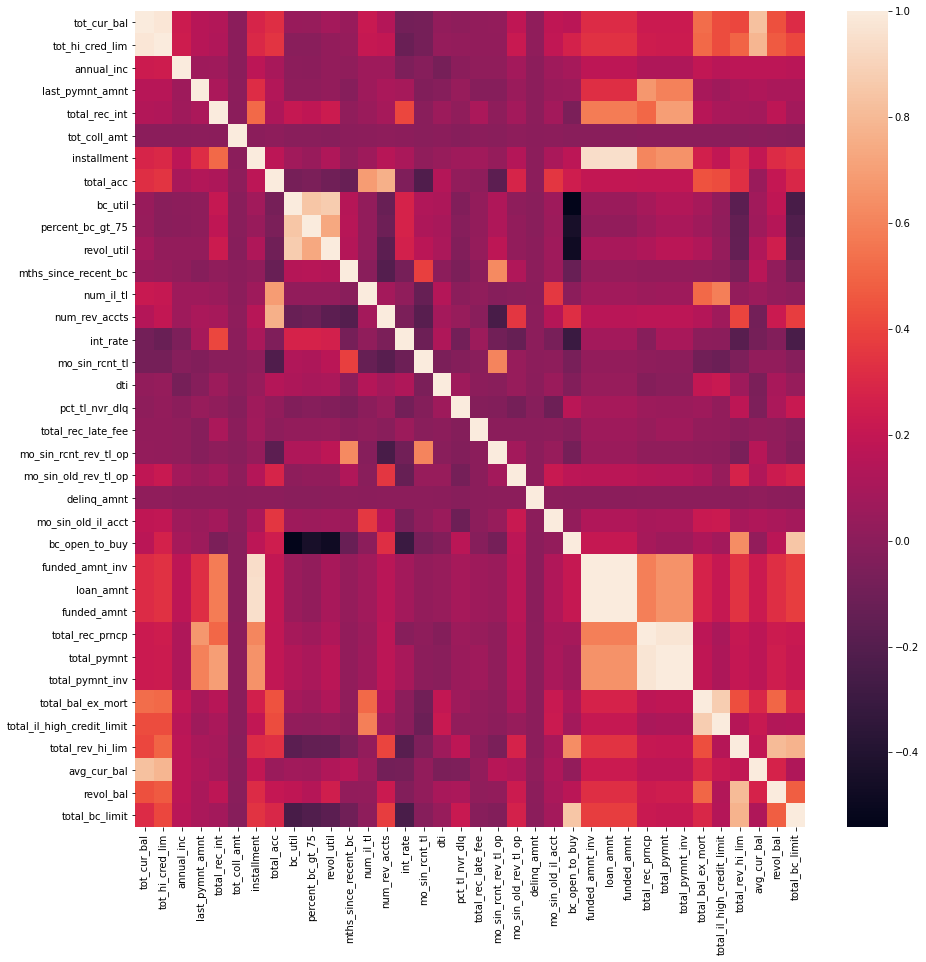

In [14]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_ord(mice_imp_x_df).corr())

In [ ]:
import seaborn as sns

sns.heatmap(train_data.isnull(), cbar=False)


In [4]:
train_data.isnull().sum()

id                       1827125
member_id                1827125
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_status        1810175
settlement_date          1810175
settlement_amount        1810175
settlement_percentage    1810175
settlement_term          1810175
Length: 145, dtype: int64

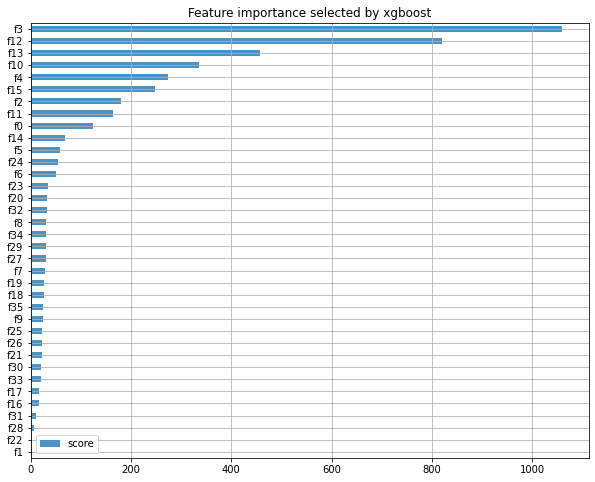

In [12]:
import xgboost as xgb
dtrain = xgb.DMatrix(mice_imp_x, y_train)
param = {'max_depth':4, 'objective':'binary:logistic', 'nthread': 8, 'eval_metric': 'auc' , 'learning_rate': 0.5, 'n_estimators': 50, 'n_jobs': -1 }

num_round = 300
bst = xgb.train(param, dtrain, num_round)

feature_important = bst.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_importance.plot(kind='barh', grid=True, figsize = (10,8), alpha = 0.8, legend = True, title = 'Feature importance selected by xgboost')

In [13]:
feature_importance

,score
f1,2
f22,2
f28,7
f31,11
f16,16
f17,16
f33,21
f30,21
f21,22
f26,22


In [14]:
selected_features = feature_importance.index[feature_importance.score > 40]


selected_features_index = [int(x[1:]) for x in selected_features]
features_names = list(numerical3.columns[selected_features_index])

selected_column_index = []
for x in features_names:
  for i in range(len(X_test.columns)):
    if X_test.columns[i] == x:
      selected_column_index.append(i)


selected_features = [int(x[1:]) for x in selected_features]
feature_x = mice_imp_x[:,selected_features]      

feature_x = mice_imp_x[:,selected_features]      

feature_x_test = mice_imp_x_test[:,selected_features]    

In [15]:
from sklearn import preprocessing

def stadardize(X):
  scaler = preprocessing.StandardScaler().fit(X)
  X = scaler.transform(X)
  return X

In [16]:
feature_x = stadardize(feature_x)

feature_x_test = stadardize(feature_x_test)

In [18]:
df = pd.DataFrame(feature_x, columns = features_names)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


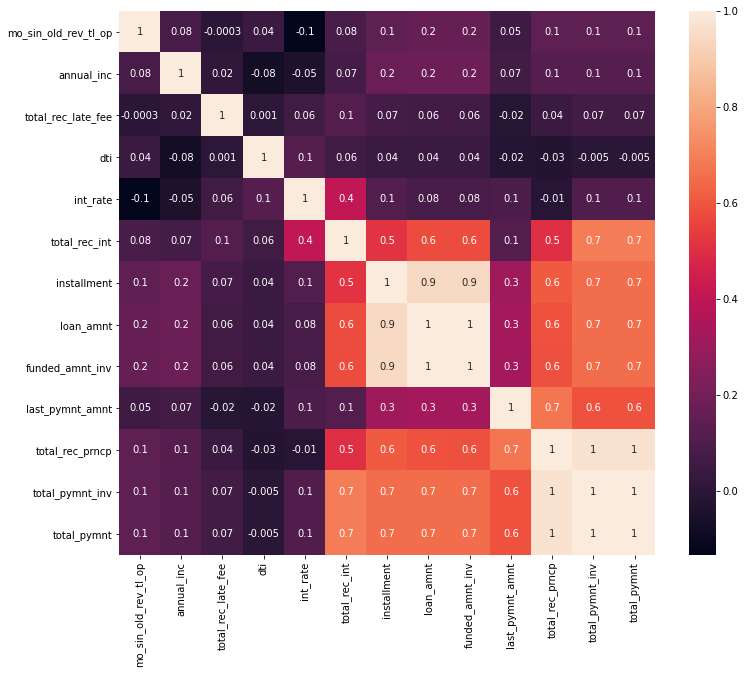

In [19]:
from scipy.cluster import hierarchy
def corr_ord(df):
  cov = np.cov(df, rowvar = False)
  order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot = True)['ivl'], dtype= 'int')
  order_features = []
  for x in order:
    for i, name in enumerate(list(df.columns)):
      if x == i:
        order_features.append(name)
        break
  return df[order_features]


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_ord(df).corr(), annot = True, fmt='.1g')

#### Test AUC

In [20]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

lr = LogisticRegression(solver='lbfgs', class_weight= 'balanced', penalty = 'l2', C = 500, n_jobs = -1, max_iter = 300)

pred = lr.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.8402427944702194

In [22]:
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# generate dataset

lr = LogisticRegression(solver='lbfgs', class_weight= 'balanced', penalty = 'l2', C = 500, n_jobs = -1, max_iter = 300)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# evaluate model
scores = cross_val_score(lr, feature_x, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.939


#### Train AUC

In [ ]:
lr = LogisticRegression(solver='lbfgs', class_weight= 'balanced', penalty = 'l2', C = 10, n_jobs = -1, max_iter = 300)

pred = lr.fit(feature_x, y_train).predict(feature_x)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred)
metrics.auc(fpr, tpr)


### Tune Hyperparamters

In [ ]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

C = [0.1, 0.01, 0.05, 0.5, 1, 5, 10, 50, 100, 500]
weights = {0: 1,1:0.085}
class_weight = ['balanced', weights]

random_grid = {'C': C
               }

lr = LogisticRegression(solver='lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 200, class_weight = 'balanced')
pprint(random_grid)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state= 5)

In [ ]:
# lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')

# lr_random.fit(feature_x, y_train)

In [ ]:
# lr_random.best_score_

In [ ]:
# lr_random.best_params_

* The best hyperparameter for regulization strength C is 500. 

* The best corrsponding AUC score is 0.939

#### Test AUC with L2 regulization

In [ ]:
lr = LogisticRegression(solver='lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 200, C = 500, class_weight = 'balanced')
pred = lr.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

#### Train AUC with L2 regulization


In [ ]:
lr = LogisticRegression(solver='lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 200, C = 500, class_weight = 'balanced')

pred = lr.fit(feature_x, y_train).predict(feature_x)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred)
metrics.auc(fpr, tpr)

In [ ]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

C = [10, 50, 100, 200, 500, 1000]


random_grid = {'C': C
               }

lr = LogisticRegression(solver='saga', penalty = 'l1', n_jobs = -1, max_iter = 200, class_weight = 'balanced')
pprint(random_grid)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state= 5)

In [ ]:
# lr_random2 = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')

# lr_random2.fit(feature_x, y_train)

In [ ]:
lr_random2.best_params_

In [ ]:
lr_random2.best_score_ 

* The best hyperparameter for regulization strength C is 100. 

* The best corrsponding AUC score is 0.902.

#### Train AUC for L1 regulizaton

In [ ]:
lr = LogisticRegression(solver='saga', penalty = 'l1', n_jobs = -1, max_iter = 1000, C = 100, class_weight = 'balanced', tol = 1e-3)

pred = lr.fit(feature_x, y_train).predict(feature_x)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred)
metrics.auc(fpr, tpr)

#### Test AUC for L1 Regulization

In [ ]:
lr = LogisticRegression(solver='saga', penalty = 'l1', n_jobs = -1, max_iter = 1000, C = 100, class_weight = 'balanced', tol = 1e-3)
pred = lr.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

#### Train and Test AUC for no regulization

In [ ]:
lr = LogisticRegression(solver='lbfgs',  n_jobs = -1, max_iter = 200, penalty = 'none', class_weight = 'balanced')

pred = lr.fit(feature_x, y_train).predict(feature_x)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred)
metrics.auc(fpr, tpr)

In [ ]:
lr = LogisticRegression(solver='lbfgs', penalty = 'none', n_jobs = -1, max_iter = 200, class_weight = 'balanced')
pred = lr.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

### Result Analysis

##### No restriction

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# generate dataset

lr = LogisticRegression(solver='lbfgs', penalty = 'none', n_jobs = -1, max_iter = 200, class_weight = 'balanced')


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
# evaluate model
scores = cross_val_score(lr, feature_x, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

In [ ]:
print('Mean ROC AUC: %.4f' % mean(scores))

#### Hyperparaters Comparasion

In [ ]:
auc_score = np.array([lr_random.cv_results_['split' + str(i) + '_test_score'] for i in range(6)])
print('The mean auc score for 10 differnece strenth of regulization is {}.'.format(np.mean(auc_score, axis = 0)))

In [ ]:
regulization_strength = ['0.01', '0.05', '0.1', '0.5', '1', '5', '10', '50', '100', '500', 'None']

mean_auc = [0.92388743, 0.93131265, 0.93318244, 0.93586343, 0.93662489, 0.93784761, 0.9381893,  0.93869786, 0.93881376, 0.93907362, 0.9392]
plt.figure(figsize=(8,6))
plt.plot(regulization_strength,mean_auc, 'o', color='red')
plt.ylabel('Average Validation AUC score')
plt.xlabel('Regulization Strength')
plt.title('Regulization Strength v.s. Avg AUC in L2 penulty')
plt.grid(True)

In [ ]:
auc_score = np.array([lr_random2.cv_results_['split' + str(i) + '_test_score'] for i in range(6)])
print('The mean auc score for 10 differnece strenth of regulization is {}.'.format(np.mean(auc_score, axis = 0)))

In [ ]:
regulization_strength = ['10', '50', '100', '200', '500', '1000']

mean_auc = np.mean(auc_score, axis = 0)
plt.figure(figsize=(8,6))
plt.plot(regulization_strength,mean_auc, 'o', color='red')
plt.ylabel('Average Validation AUC score')
plt.xlabel('Regulization Strength')
plt.title('Regulization Strength v.s. Avg AUC in L1 penulty')
plt.grid(True)